In [1]:
import pandas as pd
from sklearn.decomposition import TruncatedSVD
df=pd.read_csv("D://second//data mining//project//labeledTrainData.tsv",sep="\t")
#df.head()
#df_test=pd.read_csv("D://second//data mining//project//testData.tsv",sep="\t")
#df_test.head()
df.describe()

,sentiment
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


In [2]:
df["sentiment"].value_counts()
#1    12500
#0    12500

1    12500
0    12500
Name: sentiment, dtype: int64

In [3]:
import re
import string
from nltk import word_tokenize
import nltk
from nltk.corpus import stopwords

def remove_punct(text):
    text_nopunct = ''
    text_nopunct = re.sub('['+string.punctuation+']', '', text)
    return text_nopunct
df['Text_Clean'] = df['review'].apply(lambda x: remove_punct(x))
#nltk.download('punkt')
tokens = [word_tokenize(sen) for sen in df.Text_Clean]
def lower_token(tokens): 
    return [w.lower() for w in tokens]    
    
lower_tokens = [lower_token(token) for token in tokens]

In [4]:
#nltk.download('stopwords')
stoplist = stopwords.words('english')
def removeStopWords(tokens): 
    return [word for word in tokens if word not in stoplist]
filtered_words = [removeStopWords(sen) for sen in lower_tokens]
df['Text_Final'] = [' '.join(sen) for sen in filtered_words]
df['tokens'] = filtered_words



In [5]:
df.head()

,id,sentiment,review,Text_Clean,Text_Final,tokens
0,5814_8,1,With all this stuff going down at the moment w...,With all this stuff going down at the moment w...,stuff going moment mj ive started listening mu...,"[stuff, going, moment, mj, ive, started, liste..."
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi...",\The Classic War of the Worlds\ by Timothy Hin...,\the classic war worlds\ timothy hines enterta...,"[\the, classic, war, worlds\, timothy, hines, ..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,The film starts with a manager Nicholas Bell g...,film starts manager nicholas bell giving welco...,"[film, starts, manager, nicholas, bell, giving..."
3,3630_4,0,It must be assumed that those who praised this...,It must be assumed that those who praised this...,must assumed praised film \the greatest filmed...,"[must, assumed, praised, film, \the, greatest,..."
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,Superbly trashy and wondrously unpretentious 8...,superbly trashy wondrously unpretentious 80s e...,"[superbly, trashy, wondrously, unpretentious, ..."


In [6]:
pos = []
neg = []
for l in df.sentiment:
    if l == 0:
        pos.append(0)
        neg.append(1)
    elif l == 1:
        pos.append(1)
        neg.append(0)
df['Pos']= pos
df['Neg']= neg
sentiment_data = df[['Text_Final', 'tokens', 'sentiment', 'Pos', 'Neg']]
sentiment_data.head()

,Text_Final,tokens,sentiment,Pos,Neg
0,stuff going moment mj ive started listening mu...,"[stuff, going, moment, mj, ive, started, liste...",1,1,0
1,\the classic war worlds\ timothy hines enterta...,"[\the, classic, war, worlds\, timothy, hines, ...",1,1,0
2,film starts manager nicholas bell giving welco...,"[film, starts, manager, nicholas, bell, giving...",0,0,1
3,must assumed praised film \the greatest filmed...,"[must, assumed, praised, film, \the, greatest,...",0,0,1
4,superbly trashy wondrously unpretentious 80s e...,"[superbly, trashy, wondrously, unpretentious, ...",1,1,0


In [7]:
from sklearn.model_selection import train_test_split
list_corpus = sentiment_data["Text_Final"].tolist()
list_labels = sentiment_data["sentiment"].tolist()
data_train, data_test = train_test_split(sentiment_data, test_size=0.20, random_state=42)

3114993 words total, with a vocabulary size of 135719


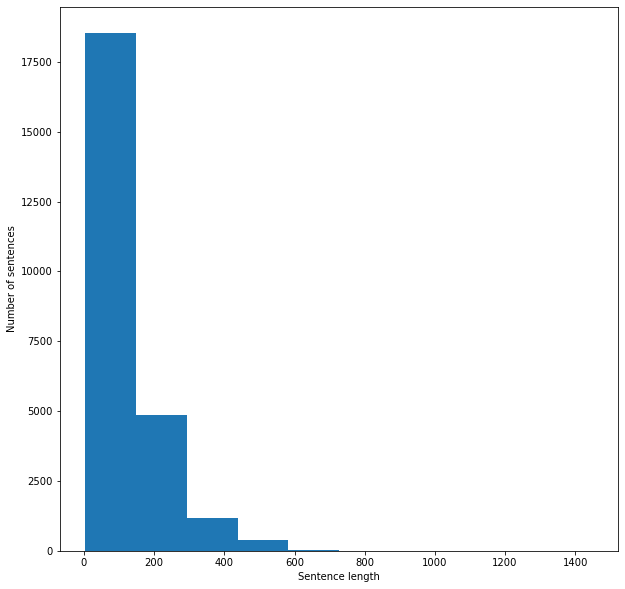

In [8]:
import matplotlib.pyplot as plt

all_training_words = [word for tokens in df["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in df["tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

627057 words total, with a vocabulary size of 56149


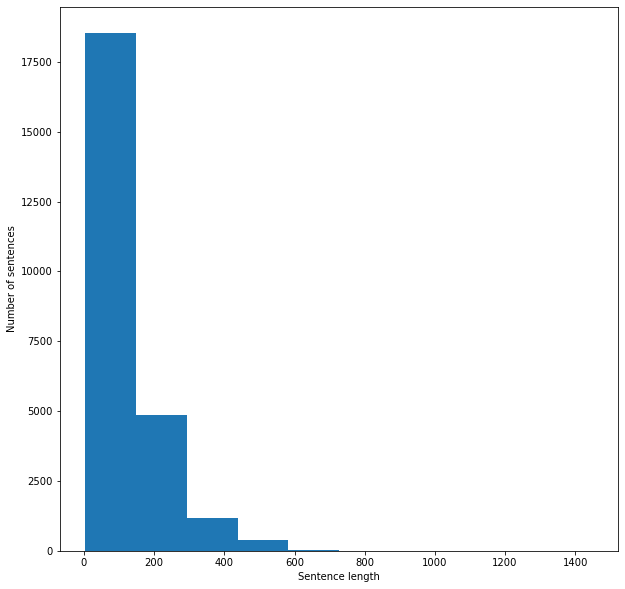

In [9]:
all_test_words = [word for tokens in data_test["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in df["tokens"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_test_words), len(TEST_VOCAB))) 

fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

In [10]:
import tensorflow as tf
config = tf.config.experimental
config.allow_growth = True #It prevents any new GPU process which consumes a GPU memory to be run on the same machine.
session = tf.compat.v1.Session()

In [11]:
#in this section we use pre learned weights for work embedding  Word embedding algorithm: word2vec
import gensim
word2vec_path = 'GoogleNews-vectors-negative300.bin.gz'
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [12]:
import numpy as np
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = clean_comments['tokens'].apply(lambda x: get_average_word2vec(x, vectors, generate_missing=generate_missing))
    return list(embeddings)

In [13]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches

def plot_LSA(test_data, test_labels, plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Irrelevant')
            green_patch = mpatches.Patch(color='blue', label='Disaster')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})

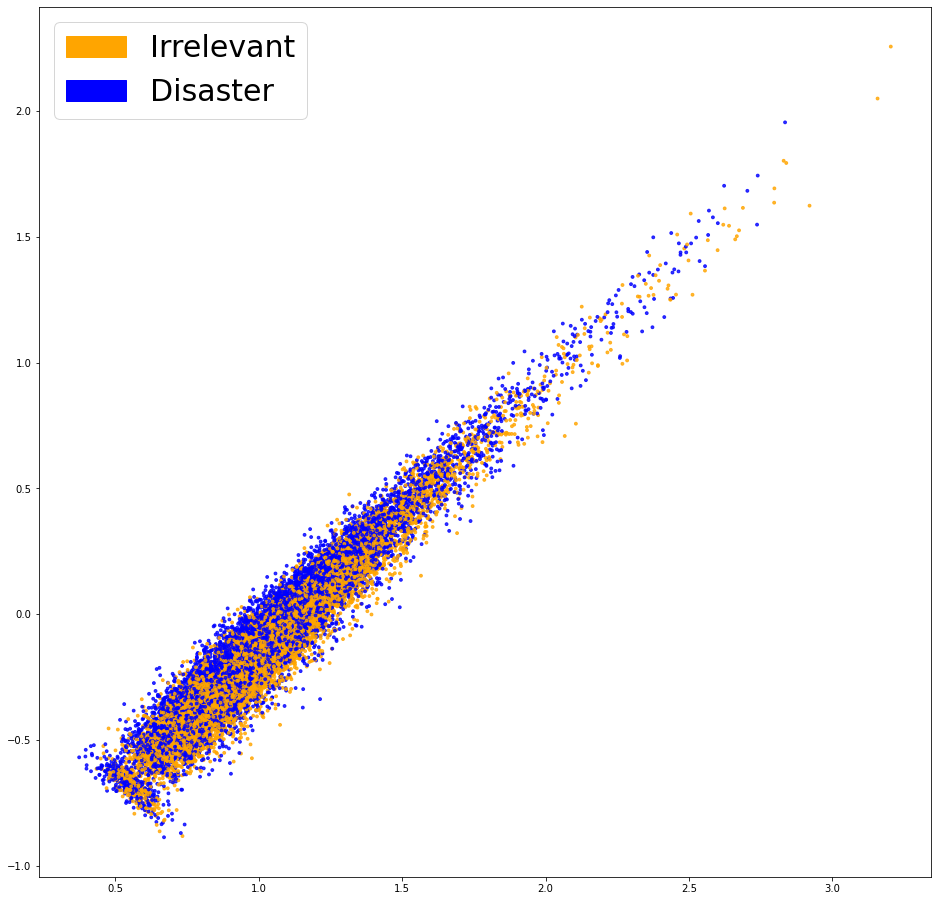

In [14]:
training_embeddings = get_word2vec_embeddings(word2vec, data_train, generate_missing=True)
len(training_embeddings)
fig1 = plt.figure(figsize=(16, 16))          
plot_LSA(training_embeddings, data_train.sentiment)
plt.show()

In [15]:
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 300
#This class allows to vectorize a text corpus, by turning each text into either a sequence of integers 
# (each integer being the index of a token in a dictionary)
# or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf...
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
#Updates internal vocabulary based on a text. In the case where texts contains lists, we assume each entry of the lists to be a token.
tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
#A "sequence" is a list of integer word indices.
training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())
train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))
train_cnn_data = tf.keras.preprocessing.sequence.pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

Found 106367 unique tokens.


In [16]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(106368, 300)


In [17]:
test_sequences = tokenizer.texts_to_sequences (data_test["Text_Final"].tolist())
test_cnn_data = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

in this section we create input trainning set and out put target

In [18]:
label_names = ['Pos', 'Neg']
y_train = data_train[label_names].values
x_train = train_cnn_data
y_tr = y_train

# create model
in this section we create model

In [19]:
model=tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,)))
model.add(tf.keras.layers.Embedding(len(train_word_index)+1,EMBEDDING_DIM,weights=[train_embedding_weights],input_length=MAX_SEQUENCE_LENGTH,trainable=False))
model.add(tf.compat.v1.keras.layers.LSTM(256))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(len(list(label_names)), activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 300)           31910400  
_________________________________________________________________
lstm (LSTM)                  (None, 256)               570368    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 32,513,922
Trainable params: 603,522
Non-trainable params: 31,910,400
_________________________________________________________________


In [20]:

num_epochs = 5
batch_size = 32
hist = model.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)

Train on 18000 samples, validate on 2000 samples
Epoch 1/5
18000/18000 [==============================] - 577s 32ms/sample - loss: 0.4844 - acc: 0.7639 - val_loss: 0.4221 - val_acc: 0.8043

# test section 
in this section we test the model 

In [21]:
predictions = model.predict(test_cnn_data, batch_size=32, verbose=1)

5000/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [24]:
labels = [1, 0]
prediction_labels=[]
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])
sum(data_test.sentiment==prediction_labels)/len(prediction_labels)

0.8422

In [25]:
from sklearn.metrics import classification_report
y_test = data_test['sentiment'].values
report = classification_report(y_test, prediction_labels, output_dict=True)
print(report)

{'0': {'precision': 0.8226544622425629, 'recall': 0.8694074969770254, 'f1-score': 0.8453850676072898, 'support': 2481}, '1': {'precision': 0.8637510513036165, 'recall': 0.81540293767368, 'f1-score': 0.8388809475188891, 'support': 2519}, 'accuracy': 0.8422, 'macro avg': {'precision': 0.8432027567730898, 'recall': 0.8424052173253527, 'f1-score': 0.8421330075630895, 'support': 5000}, 'weighted avg': {'precision': 0.8433589238115217, 'recall': 0.8422, 'f1-score': 0.8421082919067536, 'support': 5000}}


In [ ]:

test_sequences = tokenizer.texts_to_sequences(["harry potter is very very very bad and suck movie"])
xx=tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
predictions = model.predict(xx, verbose=1)
print(predictions)
print("Pos labale: %.2f " % predictions[0][0])
print("Neg labale: %.2f " % predictions[0][1])